<h3> Imports

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans,DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances, silhouette_score, pairwise_distances, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist

import skfuzzy as fuzz
from skfuzzy import cmeans
from sklearn.base import BaseEstimator, ClusterMixin

from kneed import KneeLocator
# from collections import defaultdict
# import difflib

In [2]:
data = pd.read_csv("data/data.csv")
genre_data = pd.read_csv('data/data_by_genres.csv')
year_data = pd.read_csv('data/data_by_year.csv')
artist_data = pd.read_csv('data/data_by_artist.csv')

<h3> EDA

In [9]:
print("data:")
display(data.head(2))

print()
print("data_by_genres:")
display(genre_data.head(2))

print()
print("data_by_year:")
display(year_data.head(2))

print()
print("data_by_artist:")
display(artist_data.head(2))

data:


valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   

                                             artists  danceability  \
0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...         0.279   
1                                     ['Dennis Day']         0.819   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz             0.878   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8             0.000   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   

   speechiness   tempo  
0       0.0366  80.954  
1       0.4150  60.936


data_by_genres:


mode                  genres  acousticness  danceability   duration_ms  \
0     1  21st century classical      0.979333      0.162883  1.602977e+05   
1     1                   432hz      0.494780      0.299333  1.048887e+06   

     energy  instrumentalness  liveness   loudness  speechiness       tempo  \
0  0.071317          0.606834    0.3616 -31.514333     0.040567   75.336500   
1  0.450678          0.477762    0.1310 -16.854000     0.076817  120.285667   

    valence  popularity  key  cluster  
0  0.103783   27.833333    6        1  
1  0.221750   52.500000    5        1


data_by_year:


mode  year  acousticness  danceability    duration_ms    energy  \
0     1  1921      0.886896      0.418597  260537.166667  0.231815   
1     1  1922      0.938592      0.482042  165469.746479  0.237815   

   instrumentalness  liveness   loudness  speechiness       tempo   valence  \
0          0.344878   0.20571 -17.048667     0.073662  101.531493  0.379327   
1          0.434195   0.24072 -19.275282     0.116655  100.884521  0.535549   

   popularity  key  
0    0.653333    2  
1    0.140845   10


data_by_artist:


mode  count  acousticness                           artists  danceability  \
0     1      9      0.590111  "Cats" 1981 Original London Cast      0.467222   
1     1     26      0.862538         "Cats" 1983 Broadway Cast      0.441731   

     duration_ms    energy  instrumentalness  liveness  loudness  speechiness  \
0  250318.555556  0.394003          0.011400  0.290833   -14.448     0.210389   
1  287280.000000  0.406808          0.081158  0.315215   -10.690     0.176212   

        tempo   valence  popularity  key  
0  117.518111  0.389500   38.333333    5  
1  103.044154  0.268865   30.576923    5

In [10]:
print("data info: ")

print(f"Any Null Data Found: {data.isnull().any().any()}")
print()

print(data.dtypes)
data.describe()

data info: 
Any Null Data Found: False

valence             float64
year                  int64
acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
dtype: object


valence           year   acousticness   danceability  \
count  170653.000000  170653.000000  170653.000000  170653.000000   
mean        0.528587    1976.787241       0.502115       0.537396   
std         0.263171      25.917853       0.376032       0.176138   
min         0.000000    1921.000000       0.000000       0.000000   
25%         0.317000    1956.000000       0.102000       0.415000   
50%         0.540000    1977.000000       0.516000       0.548000   
75%         0.747000    1999.000000       0.893000       0.668000   
max         1.000000    2020.000000       0.996000       0.988000   

        duration_ms         energy       explicit  instrumentalness  \
count  1.706530e+05  170653.000000  170653.000000     170653.000000   
mean   2.309483e+05       0.482389       0.084575          0.167010   
std    1.261184e+05       0.267646       0.278249          0.313475   
min    5.108000e+03       0.000000       0.000000          0.000000   
25%    1.698270e+05       0.255000       0.000000          0.000000   
50%    2.074670e+05       0.471000       0.000000          0.000216   
75%    2.624000e+05       0.703000       0.000000          0.102000   
max    5.403500e+06       1.000000       1.000000          1.000000   

                 key       liveness       loudness           mode  \
count  170653.000000  170653.000000  170653.000000  170653.000000   
mean        5.199844       0.205839     -11.467990       0.706902   
std         3.515094       0.174805       5.697943       0.455184   
min         0.000000       0.000000     -60.000000       0.000000   
25%         2.000000       0.098800     -14.615000       0.000000   
50%         5.000000       0.136000     -10.580000       1.000000   
75%         8.000000       0.261000      -7.183000       1.000000   
max        11.000000       1.000000       3.855000       1.000000   

          popularity    speechiness          tempo  
count  170653.000000  170653.000000  170653.000000  
mean       31.431794       0.098393     116.861590  
std        21.826615       0.162740      30.708533  
min         0.000000       0.000000       0.000000  
25%        11.000000       0.034900      93.421000  
50%        33.000000       0.045000     114.729000  
75%        48.000000       0.075600     135.537000  
max       100.000000       0.970000     243.507000

In [11]:
print("Genre Data Info: ")

print(f"Any Null Data Found: {genre_data.isnull().any().any()}")
print()

print(genre_data.dtypes)
genre_data.describe()

Genre Data Info: 
Any Null Data Found: False

mode                  int64
genres               object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
cluster               int32
dtype: object


mode  acousticness  danceability   duration_ms       energy  \
count  2973.000000   2973.000000   2973.000000  2.973000e+03  2973.000000   
mean      0.833165      0.401241      0.537187  2.517209e+05     0.561143   
std       0.372891      0.319760      0.150668  9.465686e+04     0.234486   
min       0.000000      0.000003      0.056900  3.094600e+04     0.001002   
25%       1.000000      0.119050      0.441202  2.063788e+05     0.395058   
50%       1.000000      0.321745      0.546496  2.375453e+05     0.601195   
75%       1.000000      0.673991      0.647500  2.772720e+05     0.730127   
max       1.000000      0.996000      0.929000  2.382587e+06     0.994667   

       instrumentalness     liveness     loudness  speechiness        tempo  \
count       2973.000000  2973.000000  2973.000000  2973.000000  2973.000000   
mean           0.211366     0.192800   -10.509848     0.083588   119.018723   
std            0.267329     0.092356     5.369202     0.080483    17.469188   
min            0.000000     0.022200   -41.825000     0.023800    47.135722   
25%            0.004835     0.137687   -12.427656     0.044900   109.198143   
50%            0.080700     0.178764    -9.221817     0.059457   119.194167   
75%            0.343333     0.220856    -6.920125     0.091000   127.508750   
max            0.992000     0.960000     0.060000     0.946219   204.212000   

           valence   popularity          key      cluster  
count  2973.000000  2973.000000  2973.000000  2973.000000  
mean      0.492748    39.919185     5.938782     2.143290  
std       0.201820    16.748723     3.368110     1.462975  
min       0.003353     0.000000     0.000000     0.000000  
25%       0.348578    32.491279     3.000000     1.000000  
50%       0.500048    43.056569     7.000000     3.000000  
75%       0.640257    51.138889     9.000000     3.000000  
max       0.980000    80.666667    11.000000     5.000000

In [12]:
print("Year Data Info: ")

print(f"Any Null Data Found: {year_data.isnull().any().any()}")
print()

print(year_data.dtypes)
year_data.describe()

Year Data Info: 
Any Null Data Found: False

mode                  int64
year                  int64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
dtype: object


mode         year  acousticness  danceability    duration_ms  \
count  100.0   100.000000    100.000000    100.000000     100.000000   
mean     1.0  1970.500000      0.556317      0.536783  227296.752234   
std      0.0    29.011492      0.275358      0.052356   25630.048065   
min      1.0  1921.000000      0.219931      0.414445  156881.657475   
25%      1.0  1945.750000      0.289516      0.500800  210889.193536   
50%      1.0  1970.500000      0.459190      0.540976  235520.850833   
75%      1.0  1995.250000      0.856711      0.570948  247702.738058   
max      1.0  2020.000000      0.962607      0.692904  267677.823086   

           energy  instrumentalness    liveness    loudness  speechiness  \
count  100.000000        100.000000  100.000000  100.000000   100.000000   
mean     0.452705          0.193582    0.208224  -11.969054     0.105861   
std      0.161738          0.122488    0.017903    3.105610     0.082128   
min      0.207948          0.016376    0.168450  -19.275282     0.049098   
25%      0.280733          0.103323    0.197509  -14.189232     0.064244   
50%      0.495997          0.127644    0.206074  -11.773061     0.085763   
75%      0.598008          0.276707    0.218493   -9.950542     0.104438   
max      0.681778          0.581701    0.264335   -6.595067     0.490001   

            tempo     valence  popularity       key  
count  100.000000  100.000000  100.000000  100.0000  
mean   116.015674    0.532120   27.376065    3.7900  
std      5.669645    0.057809   20.703197    3.5627  
min    100.884521    0.379327    0.140845    0.0000  
25%    111.718626    0.497174    3.298200    0.0000  
50%    117.455548    0.541503   33.619250    2.0000  
75%    120.606644    0.570080   44.943375    7.0000  
max    124.283129    0.663725   65.256542   10.0000

In [13]:
print("Artist Data Info: ")

print(f"Any Null Data Found: {artist_data.isnull().any().any()}")
print()

print(artist_data.dtypes)
artist_data.describe()

Artist Data Info: 
Any Null Data Found: False

mode                  int64
count                 int64
acousticness        float64
artists              object
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
dtype: object


mode         count  acousticness  danceability   duration_ms  \
count  28680.000000  28680.000000  28680.000000  28680.000000  2.868000e+04   
mean       0.759170     13.847211      0.498373      0.546490  2.388780e+05   
std        0.427595     53.372544      0.370614      0.176474  1.211318e+05   
min        0.000000      1.000000      0.000000      0.000000  1.879550e+04   
25%        1.000000      2.000000      0.122296      0.431000  1.823304e+05   
50%        1.000000      3.000000      0.478458      0.557000  2.186400e+05   
75%        1.000000      8.000000      0.896000      0.675000  2.684670e+05   
max        1.000000   3169.000000      0.996000      0.986000  5.403500e+06   

             energy  instrumentalness      liveness      loudness  \
count  28680.000000      28680.000000  28680.000000  28680.000000   
mean       0.497488          0.174756      0.202441    -11.140498   
std        0.254885          0.298406      0.140884      5.771749   
min        0.000000          0.000000      0.000000    -60.000000   
25%        0.283568          0.000004      0.110363    -13.972292   
50%        0.504000          0.001880      0.161000    -10.088938   
75%        0.702783          0.215291      0.247000     -6.889000   
max        1.000000          1.000000      0.991000      1.342000   

        speechiness         tempo       valence    popularity           key  
count  28680.000000  28680.000000  28680.000000  28680.000000  28680.000000  
mean       0.094014    115.844830      0.512723     34.060945      5.412901  
std        0.111986     25.003834      0.244421     22.376438      3.480552  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        0.039200     99.366500      0.329000     12.000000      2.000000  
50%        0.052200    115.357400      0.523243     39.000000      6.000000  
75%        0.095300    129.848750      0.703000     51.000000      8.000000  
max        0.964000    217.743000      0.991000     93.000000     11.000000

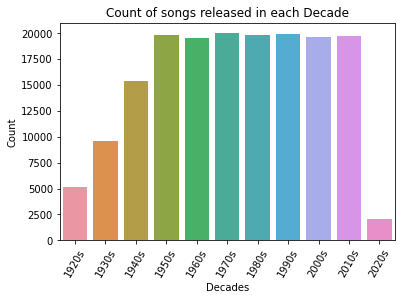

In [14]:
#create decades column feature engineering
data["decade"] = data["year"].apply(lambda year : f"{(year//10)*10}s")

#graph it
sns.countplot(x= data['decade'])

#labels and title
plt.xlabel('Decades')
plt.ylabel('Count')
plt.title('Count of songs released in each Decade')

#rotate x vertically
plt.xticks(rotation=60)

# Show the plot
plt.show()

In [15]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'valence']
fig = px.line(year_data, x = 'year', y = sound_features, title='Trend of various sound features over decades')
fig.show()

In [16]:
fig = px.line(year_data, x='year', y='loudness',title='Trend of loudness over decades')
fig.show()

In [17]:
#get data for these genres
rock_data = genre_data[genre_data["genres"] == "rock"]
rap_data = genre_data[genre_data["genres"] == "rap"]
classical_data = genre_data[genre_data["genres"] == "classical"]
indie_rock_data = genre_data[genre_data["genres"] == "indie rock"]
metal_data = genre_data[genre_data["genres"] == "metal"]
country_data = genre_data[genre_data["genres"] == "country"]
electro_data = genre_data[genre_data["genres"] == "electro"]
pop_data = genre_data[genre_data["genres"] == "pop"]
jazz_data = genre_data[genre_data["genres"] == "jazz"]
techno_data = genre_data[genre_data["genres"] == "techno"]

#combine them
combined_genres = pd.concat([rock_data, rap_data, classical_data, indie_rock_data, metal_data, 
                             country_data, electro_data, pop_data, jazz_data, techno_data])

#graph it
fig = px.bar(combined_genres, x='genres', y=sound_features, barmode='group',
            title='Trend of various sound features over 10 most well known genres')
fig.show()

In [18]:
top10_genres = genre_data.nlargest(10, 'popularity')

fig = px.bar(top10_genres, x='genres', y=sound_features, barmode='group',
            title='Trend of various sound features over top 10 genres')
fig.show()

In [19]:
top10_popular_artists = artist_data.nlargest(10, 'popularity')
top10_most_song_produced_artists = artist_data.nlargest(10, 'count')

print('Top 10 Artists that produced most songs:')
top10_most_song_produced_artists[['count','artists']].sort_values('count',ascending=False)

Top 10 Artists that produced most songs:


count            artists
8367    3169   Francisco Canaro
28561   2422   Эрнест Хемингуэй
28560   2136  Эрих Мария Ремарк
8434    1459      Frank Sinatra
10714   1256    Ignacio Corsini
27109   1200  Vladimir Horowitz
1682    1146   Arturo Toscanini
2707    1103     Billie Holiday
12378   1061        Johnny Cash
7426    1023      Elvis Presley

<h3> Clustering methods

In [30]:
data = pd.read_csv("data/data.csv")
genre_data = pd.read_csv('data/data_by_genres.csv')
year_data = pd.read_csv('data/data_by_year.csv')
artist_data = pd.read_csv('data/data_by_artist.csv')

<h4> Part 1: Genre Data <br>
    Standardization

In [4]:
genre_data.head()

mode                  genres  acousticness  danceability   duration_ms  \
0     1  21st century classical      0.979333      0.162883  1.602977e+05   
1     1                   432hz      0.494780      0.299333  1.048887e+06   
2     1                   8-bit      0.762000      0.712000  1.151770e+05   
3     1                      []      0.651417      0.529093  2.328809e+05   
4     1              a cappella      0.676557      0.538961  1.906285e+05   

     energy  instrumentalness  liveness   loudness  speechiness       tempo  \
0  0.071317          0.606834  0.361600 -31.514333     0.040567   75.336500   
1  0.450678          0.477762  0.131000 -16.854000     0.076817  120.285667   
2  0.818000          0.876000  0.126000  -9.180000     0.047000  133.444000   
3  0.419146          0.205309  0.218696 -12.288965     0.107872  112.857352   
4  0.316434          0.003003  0.172254 -12.479387     0.082851  112.110362   

    valence  popularity  key  
0  0.103783   27.833333    6  
1  0.221750   52.500000    5  
2  0.975000   48.000000    7  
3  0.513604   20.859882    7  
4  0.448249   45.820071    7

In [5]:
#first pipeline sued to calculate Inertia and Silhuette Score
start_cluster_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('kmeans', KMeans(init='k-means++'))
])

#standardize genre data
X = genre_data.select_dtypes(np.number)
start_cluster_pipeline.fit(X)

#view standardized data
scaled_genre_data = start_cluster_pipeline.named_steps['scaler'].transform(X)
scaled_genre_data = pd.DataFrame(scaled_genre_data, columns=["mode", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence", "popularity", "key"])
scaled_genre_data.head()

mode  acousticness  danceability  duration_ms    energy  \
0  0.447484      1.808197     -2.484719    -0.966000 -2.089283   
1  0.447484      0.292578     -1.578931     8.423062 -0.471170   
2  0.447484      1.128407      1.160449    -1.442757  1.095589   
3  0.447484      0.782518     -0.053735    -0.199068 -0.605666   
4  0.447484      0.861153      0.011776    -0.645517 -1.043772   

   instrumentalness  liveness  loudness  speechiness     tempo   valence  \
0          1.479575  1.828029 -3.912689    -0.534628 -2.500950 -1.927609   
1          0.996674 -0.669260 -1.181781    -0.084146  0.072537 -1.342996   
2          2.486616 -0.723408  0.247722    -0.454680  0.825894  2.389920   
3         -0.022662  0.280445 -0.331412     0.301775 -0.352759  0.103360   
4         -0.779555 -0.222497 -0.366883    -0.009152 -0.395526 -0.220526   

   popularity       key  
0   -0.721720  0.018179  
1    0.751277 -0.278774  
2    0.482555  0.315131  
3   -1.138147  0.315131  
4    0.352378  0.315131

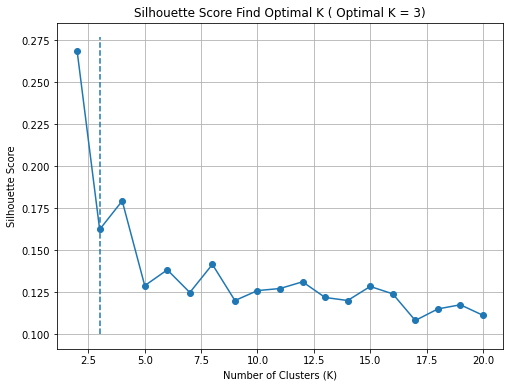

In [31]:
#silhouette_scores for best K value
k_values = range(2, 21)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(scaled_genre_data)
    score = silhouette_score(scaled_genre_data, kmeans.labels_)
    silhouette_scores.append(score)

kneedle = KneeLocator(k_values, silhouette_scores, curve='convex', direction='decreasing')
silhouette_knee_point = kneedle.knee

# Plot Silhouette Scores for different values of K and pinpoint Optimal K
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker="o")
plt.title(f"Silhouette Score Find Optimal K ( Optimal K = {silhouette_knee_point})")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)

# The elbow point 
plt.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

plt.show()

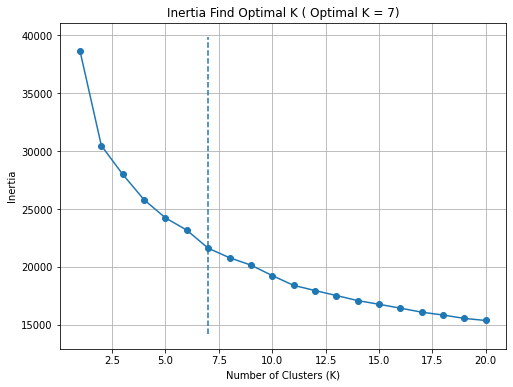

In [32]:
# Inertia for best K value
k_values = range(1, 21)
inertia_score = []

for k in k_values:
    cluster_labels = KMeans(n_clusters=k, init='k-means++')
    cluster_labels.fit(scaled_genre_data)
    inertia = cluster_labels.inertia_
    inertia_score.append(inertia)

kneedle = KneeLocator(k_values, inertia_score, curve='convex', direction='decreasing')
inertia_knee_point = kneedle.knee

# Plot Inertia for different values of K and pinpoint Optimal K
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_score, "-o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title(f"Inertia Find Optimal K ( Optimal K = {inertia_knee_point})")
plt.grid(True)

# The elbow point 
plt.vlines(kneedle.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

In [ ]:
"""
silhouette score k = 4
Inertia k = 6

Inertia doesnt have a clear elbow:
    meaning that the data doesnt have a clear cluster-like structure

Silhouette Score doesnt show a clear peak:
    meaning that there is no obvious numbers of clusters that is best
    
In cases where clusters are not well-separated, the silhouette score might be low 
because points will not be much closer to their own cluster center than to others, 
even if the inertia is steadily decreasing
"""

<h4> K-Means on Genres

In [103]:
data = pd.read_csv("data/data.csv")
genre_data = pd.read_csv('data/data_by_genres.csv')
year_data = pd.read_csv('data/data_by_year.csv')
artist_data = pd.read_csv('data/data_by_artist.csv')

In [104]:
#kmeans pipeline used after calculating Inertia and Silhuette Score
kmeans_cluster_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('kmeans', KMeans(n_clusters= inertia_knee_point, init='k-means++'))
])

X = genre_data.select_dtypes(np.number)
kmeans_cluster_pipeline.fit(X)
# centroids = kmeans_cluster_pipeline.named_steps['kmeans'].cluster_centers_

genre_data['cluster'] = kmeans_cluster_pipeline.predict(X)
genre_data.head(2)

mode                  genres  acousticness  danceability   duration_ms  \
0     1  21st century classical      0.979333      0.162883  1.602977e+05   
1     1                   432hz      0.494780      0.299333  1.048887e+06   

     energy  instrumentalness  liveness   loudness  speechiness       tempo  \
0  0.071317          0.606834    0.3616 -31.514333     0.040567   75.336500   
1  0.450678          0.477762    0.1310 -16.854000     0.076817  120.285667   

    valence  popularity  key  cluster  
0  0.103783   27.833333    6        2  
1  0.221750   52.500000    5        2

In [105]:
scaled_genre_data = kmeans_cluster_pipeline.named_steps['scaler'].transform(X)
scaled_genre_data = pd.DataFrame(scaled_genre_data, columns=["mode", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence", "popularity", "key"])
scaled_genre_data.head()

mode  acousticness  danceability  duration_ms    energy  \
0  0.447484      1.808197     -2.484719    -0.966000 -2.089283   
1  0.447484      0.292578     -1.578931     8.423062 -0.471170   
2  0.447484      1.128407      1.160449    -1.442757  1.095589   
3  0.447484      0.782518     -0.053735    -0.199068 -0.605666   
4  0.447484      0.861153      0.011776    -0.645517 -1.043772   

   instrumentalness  liveness  loudness  speechiness     tempo   valence  \
0          1.479575  1.828029 -3.912689    -0.534628 -2.500950 -1.927609   
1          0.996674 -0.669260 -1.181781    -0.084146  0.072537 -1.342996   
2          2.486616 -0.723408  0.247722    -0.454680  0.825894  2.389920   
3         -0.022662  0.280445 -0.331412     0.301775 -0.352759  0.103360   
4         -0.779555 -0.222497 -0.366883    -0.009152 -0.395526 -0.220526   

   popularity       key  
0   -0.721720  0.018179  
1    0.751277 -0.278774  
2    0.482555  0.315131  
3   -1.138147  0.315131  
4    0.352378  0.315131

In [106]:
# Visualizing the Clusters with t-SNE
tsne_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('tsne', TSNE(n_components=2, verbose=0))
])


#metrics of Kmeans on Genre
print("KMeans Metrics:")
print()

cluster_labels = kmeans_cluster_pipeline.named_steps['kmeans'].labels_

# Calculate Silhouette Score on the scaled data
scaled_data = kmeans_cluster_pipeline.named_steps['scaler'].transform(X)
silhouette_score_value = silhouette_score(scaled_data, cluster_labels)
print(f"Silhouette Score: {silhouette_score_value}")

# Calculate devies boulsin
davies_bouldin_score_value = davies_bouldin_score(scaled_data, cluster_labels)
print(f"Devies Boulsin Score: {davies_bouldin_score_value}")

# Calculate devies boulsin
calinski_harabasz_score_value = calinski_harabasz_score(scaled_data, cluster_labels)
print(f"Calinski Harabasz Score: {calinski_harabasz_score_value}")


#projections
genre_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=["x", "y"], data=genre_embedding)
projection["genres"] = genre_data["genres"]
projection["cluster"] = genre_data["cluster"]

#display
fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres']
)

fig.update_layout(
    showlegend=True,
    legend=dict(
        title='Custom Legend Title',
        bgcolor='LightSteelBlue',
        bordercolor='Black',
        borderwidth=2,
        font=dict(size=12, color='Black')
    )
)

fig.show()

KMeans Metrics:

Silhouette Score: 0.1254915255184273
Devies Boulsin Score: 1.6963288128948213
Calinski Harabasz Score: 388.9341993763643


In [11]:
#make sure clusters are indeed working
genre_data[genre_data["speechiness"] > 0.50][["genres", "cluster", "speechiness"]]

genres  cluster  speechiness
290           black comedy        4     0.698482
656           clean comedy        4     0.800410
665                 comedy        4     0.651150
797            deep comedy        4     0.740700
911          dutch cabaret        4     0.638500
1164     german literature        4     0.825531
1184  ghanaian traditional        4     0.677000
1201       gospel italiano        4     0.735000
1241              guidance        4     0.946219
1304             hoerspiel        4     0.877354
1327        hungarian folk        4     0.854500
1602      kleine hoerspiel        4     0.903500
1649         latino comedy        4     0.535400
1692    magyar alternative        4     0.854500
1836            motivation        4     0.946219
1931            new comedy        4     0.859005
2074               oratory        4     0.920000
2152                poetry        4     0.721174
2309               reading        4     0.815643
2878     vintage dutch pop        4     0.555000

<h4> Fuzzy C-Mean on Genres

In [101]:
#USING TSNE 

tsne = TSNE(n_components=2)
principalComponents = tsne.fit_transform(scaled_genre_data)
principalComponents

array([[ -4.8090534,  52.1947   ],
       [-21.585348 ,  47.13736  ],
       [-19.907846 ,  -8.56567  ],
       ...,
       [ 46.567215 , -16.875881 ],
       [ 32.02789  ,  44.346203 ],
       [ 36.44722  ,  11.3159685]], dtype=float32)

In [102]:
# Apply Fuzzy C-means
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    principalComponents.T, c= inertia_knee_point, m= 2, error= 0.005, maxiter= 1000)

#membership degrees and chosen cluster
membership_degrees = u
cluster_membership = np.argmax(u, axis=0)
genre_data["cluster"] = cluster_membership


#metrics of Fuzzy C Mean on Genre
print("Fuzzy C Mean Metrics:")
print()

# fpc
print(f"Fuzzy Partition Coefficient Score: {fpc}")

#hardening label as it is memberships
cluster_labels = np.argmax(u, axis=0)

# Calculate Silhouette Score on the scaled data
silhouette_score_value = silhouette_score(scaled_genre_data, cluster_labels)
print(f"Hardened Label Silhouette Score: {silhouette_score_value}")

# Calculate devies boulsin
davies_bouldin_score_value = davies_bouldin_score(scaled_genre_data, cluster_labels)
print(f"Hardened Label Devies Boulsin Score: {davies_bouldin_score_value}")

# Calculate devies boulsin
calinski_harabasz_score_value = calinski_harabasz_score(scaled_genre_data, cluster_labels)
print(f"Hardened Label Calinski Harabasz Score: {calinski_harabasz_score_value}")


#projections
projection = pd.DataFrame(columns=['x', 'y'], data= principalComponents)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']
projection['membership'] = membership_degrees.max(axis=0)

#display
fig = px.scatter(
    projection, 
    x= 'x', y= 'y', 
    color='membership', 
    hover_data=['x', 'y', 'genres', 'membership'],
    color_continuous_scale=px.colors.sequential.Viridis
)

# plt.title('Fuzzy C-Means on Genre with Membership Degrees')
fig.show()

Fuzzy C Mean Metrics:

Fuzzy Partition Coefficient Score: 0.5382746442288363
Hardened Label Silhouette Score: 0.07723179667533679
Hardened Label Devies Boulsin Score: 2.1182848055714523
Hardened Label Calinski Harabasz Score: 300.9531593118235


In [98]:
#USING PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_genre_data)
principalComponents

array([[ 5.9130282 , -0.02271842],
       [ 2.80844291,  4.52147428],
       [-0.75364874, -1.29775533],
       ...,
       [-0.78723742, -1.12986582],
       [ 1.63721206, -3.43124093],
       [-1.02221947, -1.43250324]])

In [99]:
# Apply Fuzzy C-means
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    principalComponents.T, c= inertia_knee_point, m= 2, error= 0.005, maxiter= 1000)

#membership degrees and chosen cluster
membership_degrees = u
cluster_membership = np.argmax(u, axis=0)
genre_data["cluster"] = cluster_membership


#metrics of Fuzzy C Mean on Genre
print("Fuzzy C Mean Metrics:")
print()

# fpc
print(f"Fuzzy Partition Coefficient Score: {fpc}")

#hardening label as it is memberships
cluster_labels = np.argmax(u, axis=0)

# Calculate Silhouette Score on the scaled data
silhouette_score_value = silhouette_score(scaled_genre_data, cluster_labels)
print(f"Hardened Label Silhouette Score: {silhouette_score_value}")

# Calculate devies boulsin
davies_bouldin_score_value = davies_bouldin_score(scaled_genre_data, cluster_labels)
print(f"Hardened Label Devies Boulsin Score: {davies_bouldin_score_value}")

# Calculate devies boulsin
calinski_harabasz_score_value = calinski_harabasz_score(scaled_genre_data, cluster_labels)
print(f"Hardened Label Calinski Harabasz Score: {calinski_harabasz_score_value}")


#projections
projection = pd.DataFrame(columns=['x', 'y'], data= principalComponents)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']
projection['membership'] = membership_degrees.max(axis=0)

#display
fig = px.scatter(
    projection, 
    x= 'x', y= 'y', 
    color='membership', 
    hover_data=['x', 'y', 'genres', 'membership'],
    color_continuous_scale=px.colors.sequential.Viridis
)

# plt.title('Fuzzy C-Means on Genre with Membership Degrees')
fig.show()

Fuzzy C Mean Metrics:

Fuzzy Partition Coefficient Score: 0.4844845218377311
Hardened Label Silhouette Score: 0.059557941236804864
Hardened Label Devies Boulsin Score: 2.6116908557777974
Hardened Label Calinski Harabasz Score: 288.0605453462047


In [ ]:
"""
THIS DOESNT WORK, TRIED MAKING FUZZY C MEAN USING PIPELINES BUT IT AINT WORKING 
IM JUST LEAVING IT HERE SO I DONT FEEL LIKE I WASTED TIME ON IT FOR NOTHING
"""
# #preparing fcm for Pipeline
# class FuzzyCMeans(BaseEstimator, ClusterMixin):
#     def __init__(self, n_clusters=inertia_knee_point, max_iter=1000, m=3):
#         self.n_clusters = n_clusters
#         self.max_iter = max_iter
#         self.m = m
#         self.centers_ = None
#         self.u_ = None

#     def fit(self, X, y=None):
#         self.cntr, u, _, _, _, _, _ = cmeans(X.T, self.n_clusters, self.m, error=0.005, maxiter=self.max_iter)
#         self.u_ = u
# #         self.centers_ = u.argmax(axis=0)
#         return self

#     def predict(self, X):
#         u, _, _, _, _, _ = fuzz.cluster.cmeans_predict(
#             scaled_genre_data.T, self.cntr, self.m, error=0.005, maxiter=self.max_iter
#         )
#         return np.argmax(u, axis=0)

# fcm_pipeline = Pipeline([
#     ('scaler', StandardScaler()), 
#     ('fcm', FuzzyCMeans())
# ])

# scaled_genre_data = scaled_genre_data.select_dtypes(np.number)
# fcm_pipeline.fit(scaled_genre_data)

# genre_data['cluster'] = fcm_pipeline.predict(scaled_genre_data)

# # Visualizing the Clusters with t-SNE
# tsne_pipeline = Pipeline([
#     ('scaler', StandardScaler()), 
#     ('tsne', TSNE(n_components=2, verbose=0))
# ])

# genre_embedding = tsne_pipeline.fit_transform(X)
# projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
# projection['genres'] = genre_data['genres']
# projection['cluster'] = genre_data['cluster']

# fig = px.scatter(
#     projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres']
# )
# fig.show()

<h4> DBSCAN on Genres

In [92]:
data = pd.read_csv("data/data.csv")
genre_data = pd.read_csv('data/data_by_genres.csv')
year_data = pd.read_csv('data/data_by_year.csv')
artist_data = pd.read_csv('data/data_by_artist.csv')

In [93]:
#first pipeline sued to calculate Inertia and Silhuette Score
start_cluster_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('kmeans', KMeans(init='k-means++'))
])

#standardize genre data
X = genre_data.select_dtypes(np.number)
start_cluster_pipeline.fit(X)

#view standardized data
scaled_genre_data = start_cluster_pipeline.named_steps['scaler'].transform(X)
scaled_genre_data = pd.DataFrame(scaled_genre_data, columns=["mode", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence", "popularity", "key"])
scaled_genre_data.head()


mode  acousticness  danceability  duration_ms    energy  \
0  0.447484      1.808197     -2.484719    -0.966000 -2.089283   
1  0.447484      0.292578     -1.578931     8.423062 -0.471170   
2  0.447484      1.128407      1.160449    -1.442757  1.095589   
3  0.447484      0.782518     -0.053735    -0.199068 -0.605666   
4  0.447484      0.861153      0.011776    -0.645517 -1.043772   

   instrumentalness  liveness  loudness  speechiness     tempo   valence  \
0          1.479575  1.828029 -3.912689    -0.534628 -2.500950 -1.927609   
1          0.996674 -0.669260 -1.181781    -0.084146  0.072537 -1.342996   
2          2.486616 -0.723408  0.247722    -0.454680  0.825894  2.389920   
3         -0.022662  0.280445 -0.331412     0.301775 -0.352759  0.103360   
4         -0.779555 -0.222497 -0.366883    -0.009152 -0.395526 -0.220526   

   popularity       key  
0   -0.721720  0.018179  
1    0.751277 -0.278774  
2    0.482555  0.315131  
3   -1.138147  0.315131  
4    0.352378  0.315131

In [96]:
#dimentionaluity reduction to 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric="euclidean")
X_tsne = tsne.fit_transform(scaled_genre_data)

# The result is in X_tsne
print("New shape of data:", X_tsne.shape)

#dbscan hyperparameters
dbscan = DBSCAN(eps=0.8, min_samples=9) 
clusters = dbscan.fit_predict(X_tsne)
genre_data['cluster'] = clusters
print(np.unique(clusters))

New shape of data: (2973, 2)
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26]


In [97]:
#metrics
print("DBSCAN Metrics:")
print()
cluster_labels = dbscan.labels_
unique_clusters = set(clusters)
print(f"Number of clusters: {len(unique_clusters) - (1 if -1 in unique_clusters else 0)}")
print(f"Noise points: {np.sum(clusters == -1)}")

# Calculate Silhouette Score on the scaled data
silhouette_score_value = silhouette_score(scaled_genre_data, cluster_labels)
print(f"Silhouette Score: {silhouette_score_value}")
# Calculate devies boulsin
davies_bouldin_score_value = davies_bouldin_score(scaled_genre_data, cluster_labels)
print(f"Devies Boulsin Score: {davies_bouldin_score_value}")
# Calculate devies boulsin
calinski_harabasz_score_value = calinski_harabasz_score(scaled_genre_data, cluster_labels)
print(f"Hardened Label Calinski Harabasz Score: {calinski_harabasz_score_value}")


#graph data
projection = pd.DataFrame(columns=['x', 'y'], data=X_tsne)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres']
)
fig.show()

DBSCAN Metrics:

Number of clusters: 27
Noise points: 289
Silhouette Score: -0.06405014431891623
Devies Boulsin Score: 2.504046468221073
Hardened Label Calinski Harabasz Score: 99.32973567558847


<h4> Gaussian Mixture on Genres

<h4> Optic on Genres

<h4> Hierarchial  on Genres

<h4> Part 2: Artist Data<br>
    Standardization 

In [ ]:
artist_data.head()

In [ ]:
X = artist_data.select_dtypes(np.number)
kmeans_cluster_pipeline.fit(X)

#view standardized data
scaled_artist_data = kmeans_cluster_pipeline.named_steps['scaler'].transform(X)
scaled_artist_data = pd.DataFrame(scaled_artist_data, columns=["mode", "count", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence", "popularity", "key"])
scaled_artist_data.head()

<h4> K-Means on Artist

In [223]:
#use created pipline and apply it on Artist Data
X = artist_data.select_dtypes(np.number)
kmeans_cluster_pipeline.fit(X)
centroids = kmeans_cluster_pipeline.named_steps['kmeans'].cluster_centers_

artist_data['cluster'] = kmeans_cluster_pipeline.predict(X)
artist_data.head(2)

mode  count  acousticness                           artists  danceability  \
0     1      9      0.590111  "Cats" 1981 Original London Cast      0.467222   
1     1     26      0.862538         "Cats" 1983 Broadway Cast      0.441731   

     duration_ms    energy  instrumentalness  liveness  loudness  speechiness  \
0  250318.555556  0.394003          0.011400  0.290833   -14.448     0.210389   
1  287280.000000  0.406808          0.081158  0.315215   -10.690     0.176212   

        tempo   valence  popularity  key  cluster  
0  117.518111  0.389500   38.333333    5        1  
1  103.044154  0.268865   30.576923    5        1

In [224]:
# Visualizing the Clusters with t-SNE
artist_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=artist_embedding)
projection['artists'] = artist_data['artists']
projection['cluster'] = artist_data['cluster']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'artists']
)
fig.show()

<h4> Fuzzy C-Mean on Artist

<h4> DBSCAN on Artist

<h4> Gaussian Mixture on Genres

<!-- <h4> Kmeans on Songs -->
<h4> Part 3: Songs Data<br>
    Kmeans on Songs

In [11]:
X = data.select_dtypes(np.number)
kmeans_cluster_pipeline.fit(X)
song_cluster_labels = kmeans_cluster_pipeline.predict(X)

data["cluster_label"] = song_cluster_labels
data.head(2)

valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   

                                             artists  danceability  \
0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...         0.279   
1                                     ['Dennis Day']         0.819   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz             0.878   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8             0.000   

   key  liveness  loudness  mode  \
0   10     0.665   -20.096     1   
1    7     0.160   -12.441     1   

                                                name  popularity release_date  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...           4         1921   
1                            Clancy Lowered the Boom           5         1921   

   speechiness   tempo  cluster_label  
0       0.0366  80.954              0  
1       0.4150  60.936              5

In [ ]:
# Visualizing the Clusters with t-SNE
song_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=["x", "y"], data = song_embedding)
projection["artists"] = data["artists"]
projection["song"] = data["name"]
projection["cluster"] = data["cluster_label"]

fig = px.scatter(
    projection, x="x", y="y", color="cluster", hover_data=["x", "y", "artists", "song"]
)
fig.show()

<h3> Recommendation System using Spotify API

In [ ]:
#imports
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=CLIENT_ID, 
                                                           client_secret=CLIENT_SECRET))

In [ ]:
#This will return None if the data of the song isnt found

#find song using spotify search
def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q= f'track: {name} year: {year}')
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)

number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']

#check if song is in dataset, if not, check spotify
def get_song_data(song, spotify_data):
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name']) & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data
    
    except IndexError:
        return find_song(song['name'], song['year'])
    
def get_mean_vector(song_list, spotify_data):
    song_vectors = []
    
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print(f"Warning: {song['name']} does not exist in Spotify or in dataset")
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)

def flatten_dict_list(dict_list):
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict


def recommend_songs( song_list, spotify_data, n_songs=5):
    metadata_cols = ["name", "year", "artists", "cluster_label"]
    song_dict = flatten_dict_list(song_list)
    
    song_center = get_mean_vector(song_list, spotify_data)
    scaler = StandardScaler()
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    rec_songs = spotify_data.iloc[index]
    return rec_songs[metadata_cols]

In [ ]:
#how artists column data looks like
print(data["artists"][0])

data[data["artists"] == "['Eminem']"].head()

In [ ]:
recommend_songs([
    {'name': 'The Real Slim Shady', 'year':2000},
    {'name': 'My Name Is', 'year':1999},
    {'name': "Role Model", 'year':1999},
    {'name': 'The Way I Am', 'year':2000},
    {'name': 'Believe', 'year':2017},
    {'name': 'Darkness', 'year':2017},
    {'name': 'Evil Twin', 'year':2013},
    {'name': 'So Much Better', 'year':2013},
    
], data, n_songs = 10)